In [128]:
import sys
# sys.path.append('/home/abigaile-woodbury/Research/cp_reach')  # UPDATE path as needed
sys.path.append('/home/micah/Research/development/cp_reach')
import json
import numpy as np
import matplotlib.pyplot as plt
import cp_reach as cp

import cp_reach.satellite.invariant_set2 as invariant_set
import cp_reach.satellite.plotting as plotting
import sympy as sp

import cp_reach.satellite.mission as sat_sim
import cyecca.lie as lie
import casadi as ca

In [129]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
%autoreload 2

# Define Mission Parameters

In [141]:
thrust = 30
ang_vel_dist_deg = 10 # in degrees
ang_vel_dist_rad = np.deg2rad(ang_vel_dist_deg)
gravity_err = 0.0003 # m/s^2
Kp = 1
Kd = 1
Kpq = 1
Kdq = 1
control_gains = (Kp, Kd, Kpq, Kdq)
acc = [thrust, 0, 0]

In [142]:
def do_burn_reference(t_vect):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    p_index = sat_burn.model['p_index']
    sat_burn.model['p0_dict']['w_d_phase'] = 0
    sat_burn.model['p0_dict']['w_d_freq'] = 0
    
    sat_burn.model['p0_dict']['w_d_amp'] = 0
    sat_burn.model['p0_dict']['thrust'] = thrust
    sat_burn.model['p0_dict']['Kp'] = Kp
    sat_burn.model['p0_dict']['Kd'] = Kd
    sat_burn.model['p0_dict']['Kpq'] = Kpq
    sat_burn.model['p0_dict']['Kdq'] = Kdq
    sat_burn.model['p0_dict']['ang_vel_saturation'] = ang_vel_saturation
    
    res = sat_burn.simulate(t_vect, integrator='rk')
    return res

def do_burn_monte_carlo(t_vect, n_runs=10):
    sat_burn = sat_sim.SatSimBurn()
    data = []
    for i in range(n_runs):
        p_index = sat_burn.model['p_index']
        sat_burn.model['p0_dict']['w_d_x_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_y_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_z_phase'] = np.random.uniform(0, 2*np.pi)
        sat_burn.model['p0_dict']['w_d_freq'] = 10**np.random.uniform(-2, 1)

        
        sat_burn.model['p0_dict']['w_d_amp'] = ang_vel_dist_rad
        sat_burn.model['p0_dict']['thrust'] = thrust
        sat_burn.model['p0_dict']['Kp'] = Kp
        sat_burn.model['p0_dict']['Kd'] = Kd
        sat_burn.model['p0_dict']['Kpq'] = Kpq
        sat_burn.model['p0_dict']['Kdq'] = Kdq
        sat_burn.model['p0_dict']['ang_vel_saturation'] = ang_vel_saturation

        res = sat_burn.simulate(t_vect, integrator='rk')
        data.append(res)
    return data

# 10 Second Burn - Monte Carlo and Reference

In [133]:
# Perform Monte Carlo Simulation for Burn Phase
t_burn_vect = np.arange(0, 10, 0.01)
data_burn_ref = do_burn_reference(t_burn_vect)
data_burn = do_burn_monte_carlo(t_vect=t_burn_vect, n_runs=100)

In [147]:
xi_points, eta_points, omega_points, bounds, sol = invariant_set.solve(ang_vel_dist_rad, gravity_err, acc, control_gains, num_points=10000)

[30, 0, 0]


In [ ]:
def gravity_bound(r, x_index, mu, eps=1e-9):
    X = np.array(ca.DM(r['xf']))
    pa = np.vstack([X[x_index['px_a']], X[x_index['py_a']], X[x_index['pz_a']]])
    pb = np.vstack([X[x_index['px_b']], X[x_index['py_b']], X[x_index['pz_b']]])
    dp = pa - pb
    rb = np.linalg.norm(pb, axis=0)                  # ||p_ref||
    rlb = np.maximum(eps, rb - np.linalg.norm(dp, axis=0))  # radius lower bound
    ell_t = 2.0 * mu / (rlb**3)                      # per-time Lipschitz l(t)
    dg_bound_t = ell_t * np.linalg.norm(dp, axis=0)  # ||δg|| ≤ l(t)||δp||
    ell_global = 2.0 * mu / (np.min(rlb)**3)         # worst-case l over time
    dg_bound_global = ell_global * np.max(np.linalg.norm(dp, axis=0))
    return rlb, ell_t, dg_bound_t, ell_global, dg_bound_global


In [ ]:
gravity_bound(17.3, 3.986e14)

Text(0, 0.5, 'deltav z')

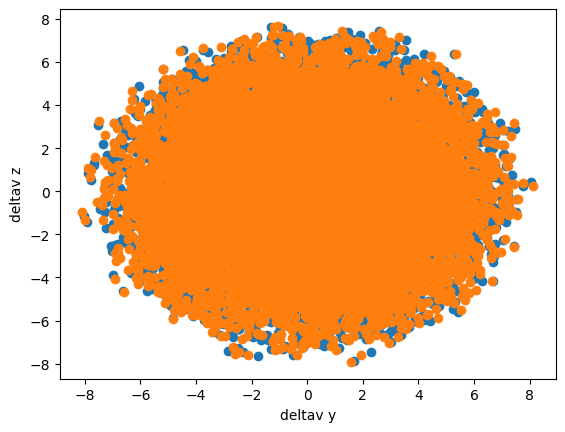

In [143]:
i = 4
j = 5
plt.scatter(eta_points[i,:],eta_points[j,:])
plt.scatter(xi_points[i,:],xi_points[j,:])
plt.xlabel('deltav y')
plt.ylabel('deltav z')

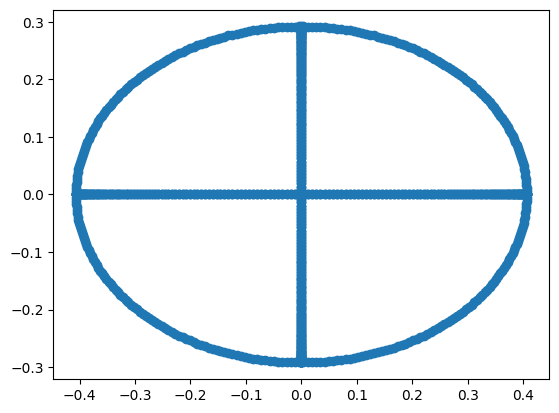

In [144]:
i = 0
j = 1
plt.scatter(omega_points[i,:],omega_points[j,:])
# plt.scatter(xi_points[i,:],xi_points[j,:])

In [145]:
eta_points.shape

(9, 10000)

## Compute LMI

In [138]:
bounds

array([[ -1.30125328,   0.7501493 ],
       [-10.38706939,  10.6244902 ],
       [-10.53185037,  10.68615836],
       [ -1.13084389,   0.72720817],
       [ -8.02561651,   8.05299686],
       [ -7.85757446,   7.60613307],
       [ -0.28400214,   0.27924351],
       [ -0.29194883,   0.27938707],
       [ -0.38943582,   0.38652389],
       [ -0.40664302,   0.40664302],
       [ -0.29190473,   0.29190473],
       [ -0.29189182,   0.29189182]])

## Plot

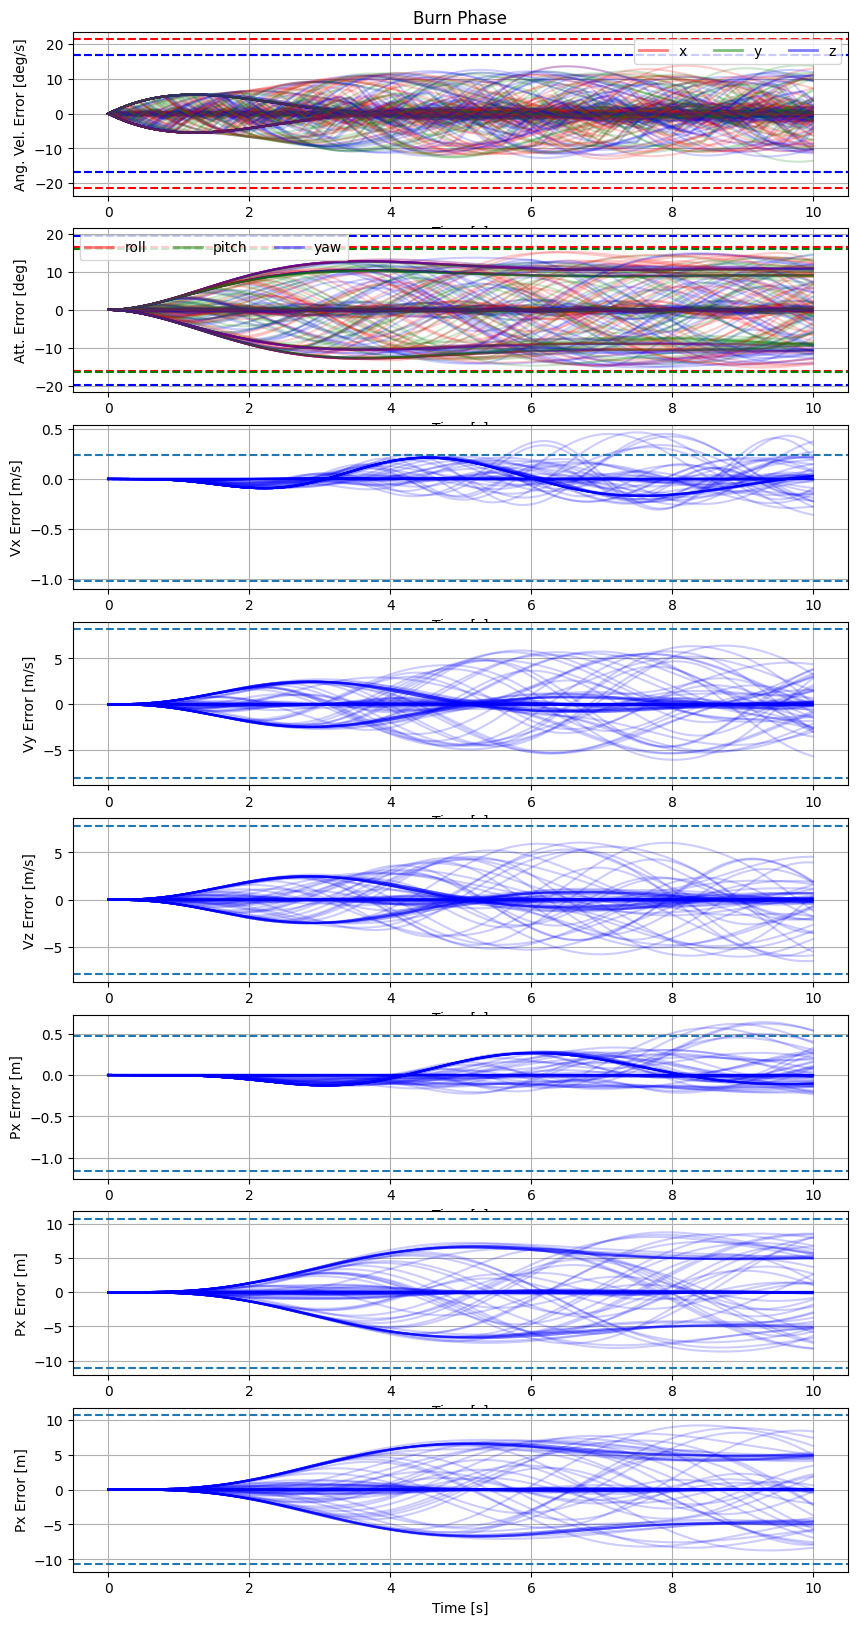

In [148]:
def burn_plotting(data_burn, bounds):
    fig, axes = plt.subplots(8, 1, figsize=(10, 20))
    axes[0].set_title('Burn Phase')
    colors = ['r','g','b']

    # Angular Velocity
    plotting.plot_burn_angular_velocity(axes[0], data_burn)
    for i in range(3):
        axes[0].axhline(y=np.rad2deg(bounds[9+i, 0]), linestyle='--', color=colors[i])
        axes[0].axhline(y=np.rad2deg(bounds[9+i, 1]), linestyle='--', color=colors[i])


    # Attitude
    plotting.plot_burn_attitude(axes[1], data_burn)
    for i in range(3):
        axes[1].axhline(y=np.rad2deg(bounds[6+i, 0]), linestyle='--', color=colors[i])
        axes[1].axhline(y=np.rad2deg(bounds[6+i, 1]), linestyle='--', color=colors[i])

    # Vx
    plotting.plot_burn_delta_vx_error(axes[2], data_burn)
    axes[2].axhline(y=bounds[3, 0], linestyle='--')
    axes[2].axhline(y=bounds[3, 1], linestyle='--')

    #V y
    plotting.plot_burn_delta_vy_error(axes[3], data_burn)
    axes[3].axhline(y=bounds[4, 0], linestyle='--')
    axes[3].axhline(y=bounds[4, 1], linestyle='--')

    # Vz
    plotting.plot_burn_delta_vz_error(axes[4], data_burn)
    axes[4].axhline(y=bounds[5, 0], linestyle='--')
    axes[4].axhline(y=bounds[5, 1], linestyle='--')

    # Px
    plotting.plot_burn_x_error(axes[5], data_burn)
    axes[5].axhline(y=bounds[0, 0], linestyle='--')
    axes[5].axhline(y=bounds[0, 1], linestyle='--')

    # Py
    plotting.plot_burn_y_error(axes[6], data_burn)
    axes[6].axhline(y=bounds[1, 0], linestyle='--')
    axes[6].axhline(y=bounds[1, 1], linestyle='--')

    # Pz
    plotting.plot_burn_z_error(axes[7], data_burn)
    axes[7].axhline(y=bounds[2, 0], linestyle='--')
    axes[7].axhline(y=bounds[2, 1], linestyle='--')
    
burn_plotting(data_burn, bounds)

In [140]:
vec = np.array([0, 0, 0, 30, 0, 0, 0, 0, 0])

xi = lie.se23.elem(ca.DM(vec)) # Lie Algebra
ad = lie.se23.adjoint(xi)
ad

SX(
[[00, 00, 00, 00, 00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00, 00, 00, 00, -30], 
 [00, 00, 00, 00, 00, 00, 00, 30, 00], 
 [00, 00, 00, 00, 00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00, 00, 00, 00, 00], 
 [00, 00, 00, 00, 00, 00, 00, 00, 00]])